# Common Risk Factors in Cryptocurrency

# Master Thesis Project

<div style="text-align: right;font-size: 0.8em">Document Version 1.0.0</div>

This file requires `pandas`, `datetime`, `numpy`, `wand`, `pdf2image`, `Pillow`, and `math` to run. If one of these imports fails, please install the corresponding library and make sure that you have activated the corresponding virtual environment.

The project follows closely the methodology proposed by Liu, Tsyvinski, and Wu (2022) in their paper titled [Common Risk Factors in Cryptocurrency](https://onlinelibrary.wiley.com/doi/abs/10.1111/jofi.13119). Researchers and practitioners can use this paper to check the results of the paper and perhaps retrieve an updated version of the basic findings. They can also use it as a toolbox to use for other projects or to run an extended analysis including further risk factors. Finally, asset management firm may use this code to assess the risk of their portfolio or to firm anomalies in the returns of cryptocurrencies.

For this analysis, I occasionally had to make assumption, for example, regarding the procedure to convert daily to weekly data. This is especially so because the authors of the paper did not provide a detailed enough description of their decisions. There are other, perhabs better ways of doing certain steps and I am always grateful for any feedback that you might provide.

The order of the following sections is closely following the structure of the paper. The outline is:
* <a href="#I._Data">I. Data</a>: The files for all data sources can be found in the data folder. The main blockchain trading data is retrieved from CoinGecko (coingecko_data.py). It is advisable to download the cryptocurrency data set in smaller chunks (for example, 100 cryptocurrencies), since the data set is relatively large and takes long to download due to the API limit. The merge_data.py file can then be used to merge all individal cryptocurrency data files into one large file that is supposed to be loaded into the code below. The daily crptocurrency (aka coin) data is converted to weekly returns using the last available prices: $$r_t = \frac{p_t-p_{t-1}}{p_{t-1}}$$ One can also compute log-returns instead. The definition of the weeks is as follows: The first 7 days of a given year are the first week. The following 50 weeks consist of 7 days each. The last week has either 8 or 9 days (if the year is a leap year). The code below computes the weekly trading data (inclduing returns) and the weekly market returns. Moreover, it generates the first table of the paper. Consequently, 3 time series graphs plotting the returns of Bitcoin, Ripple, and Ethereum against the market returns is shown.

* <a href="#II._Cross-Sectional_Return_Predictor">II. Cross-Sectional Return Predictors</a>:
    * <a href="#A._Size_Characteristics">A. Size Characteristics</a>:
    * <a href="#B._Momentum_Characteristics">B. Momentum Characteristics</a>:
    * <a href="#C._Volume_Characteristics">C. Volume Characteristics</a>:
    * <a href="#D._Volatility_Characteristics">D. Volatility Characteristics</a>:
    * <a href="#E._Insignificant_Strategies">E. Insignificant Strategies</a>:

<a id="I._Data"></a> 
# I. Data

In [1]:
import pandas as pd, numpy as np, math, time, os, datetime as dt, data.coingecko_data as coingecko_data, helpers, data.fred_data as fred_data
pd.options.mode.chained_assignment = None
from wand.image import Image

# specify the data range for the analysis
# in the paper, the authors start on 2014-01-01 due to data availability
start_date = pd.to_datetime("2014-01-01")
end_date = pd.to_datetime("today")

# select the path to the directory where you want to store the data
directory = r"/Users/Marc/Desktop/Past Affairs/Past Universities/SSE Courses/Master Thesis/Data"

# downloading the data from CoinGecko.com and storing it in smaller data subsets at the specified location
# the data contains daily prices, market caps, and trading volumes
# this step can take up to 2 days due to the API traffic limit
# we are also always checking if the subsequent files already exist (/cg_data.csv, /cg_weekly_data.csv, /cg_weekly_returns.csv, /market_weekly_returns.csv)
# this helps in case the previous files have been deleted
files = ["/coingecko", "/cg_data.csv", "/cg_weekly_returns_data.csv", "/market_weekly_returns.csv"]
if any(os.path.exists(directory + file) for file in files):
    # if at least 1 file already exists
    print("The individual data files already exist.")
else:
    # if the file or the subsequent files do not already exist
    coingecko_data.retrieve_data(start_date, end_date, path=directory)

# merging the data subsets and storing the result at the specified location
# this task also absorbs part of the preprocessing, so it's recommended to run this step in any case 
# this step can take long
if any(os.path.exists(directory + file) for file in files[1:]):
    # if at least 1 file already exists
    print("The data was already merged into a single file.")  
else:
    # if the file or the subsequent files do not already exist
    helpers.merge_data(path=directory)  

# the data was retrieved on 2023-01-13
daily_trading_data = pd.read_csv(directory + "/cg_data.csv", index_col=["date"])
daily_trading_data.index = pd.to_datetime(daily_trading_data.index)

# downloading the data since the conversion process might also take a long time
if any(os.path.exists(directory + file) for file in files[2:]):
    # if at least 1 file already exists
    print("The data has already been converted to weekly frequency.")
    weekly_returns_data = pd.read_csv(directory + "/cg_weekly_returns_data.csv", index_col=["date"])
    weekly_returns_data.index = pd.to_datetime(weekly_returns_data.index)
else:
    # this function converts the frequency and also computes the retunrs series
    # this step can take a while
    weekly_returns_data = helpers.convert_frequency(daily_trading_data, method="last", returns=True)
    # some returns are exorbitant (above 10000%)and need to be removed
    weekly_returns_data["return"].where(weekly_returns_data["return"] < 100, np.nan, inplace=True)
    # downloading the data
    weekly_returns_data.to_csv(directory + "/cg_weekly_returns_data.csv")

# computing the risk-free rate
# a pd dataframe with columns for date and DGS1MO
risk_free_rate_daily_data = fred_data.retrieve_data(start_date, end_date, series_ids = ["DGS1MO"], download=False)
# converting to weekly data
date_range = pd.date_range(start=risk_free_rate_daily_data.index.min(), end=risk_free_rate_daily_data.index.max(), freq="W-SUN")
risk_free_rate = risk_free_rate_daily_data.resample("W-SUN").last().reindex(date_range)

# downloading the data since the returns computation process might also take a long time
if any(os.path.exists(directory + file) for file in files[3:]):
    # if at least 1 file already exists
    print("The market returns data has already been computed.")
    market_weekly_returns = pd.read_csv(directory + "/market_weekly_returns.csv", index_col=["date"])
    market_weekly_returns.index = pd.to_datetime(market_weekly_returns.index)
else:
    # Compute the excess weighted average of the returns using the market capitalization as the weight
    market_weekly_returns = weekly_returns_data.groupby(weekly_returns_data.index).apply(lambda x: (x["return"]*x["market_cap"]).sum()/x["market_cap"].sum())
    market_weekly_returns.rename("market_return", inplace=True)
    market_weekly_returns = market_weekly_returns.to_frame()
    market_weekly_returns.index = pd.to_datetime(market_weekly_returns.index)
    # filling in the missing values with NaNs
    date_range = pd.date_range(start=weekly_returns_data.index.min(), end=weekly_returns_data.index.max(), freq="W")
    market_weekly_returns = market_weekly_returns.reindex(date_range)
    market_weekly_returns.index.name = "date"
    market_weekly_returns["risk_free_rate"] = risk_free_rate["DGS1MO"].tolist()
    market_weekly_returns["market_return"] = market_weekly_returns["market_return"] - market_weekly_returns["risk_free_rate"]
    market_weekly_returns.drop("risk_free_rate", inplace=True, axis=1)
    # downloading the data
    market_weekly_returns.to_csv(directory + "/market_weekly_returns.csv")

# inverting the colors in the PDF in case the user is using dark mode
if input("Is your editor is dark mode? y/n ") in ["Y", "y"]:
    invert = True
else:
    invert = False

# creates a temporary PDF file named "cover.pdf"
# repeating the process overwrites the file
# we need also the daily data since Panel A is built on daily data
# this step takes about 1 hour
helpers.render_summary_statistics(daily_data=daily_trading_data, market_weekly_data=market_weekly_returns, weekly_data=weekly_returns_data, invert=invert)

pdf_path = os.getcwd() + "/cover.pdf"
# printing the PDF
# this code has to be in the main file
img = Image(filename=pdf_path, resolution=100)
img

The individual data files already exist.
The data was already merged into a single file.


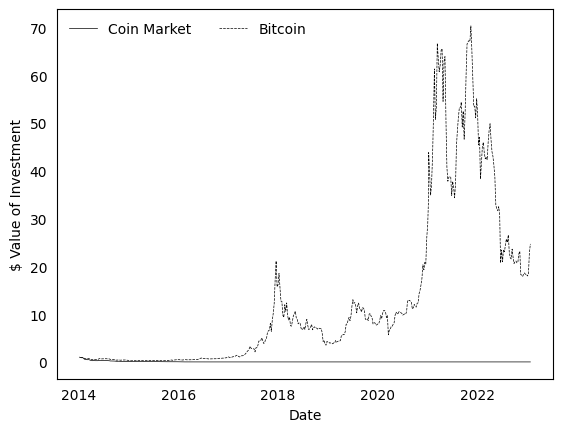

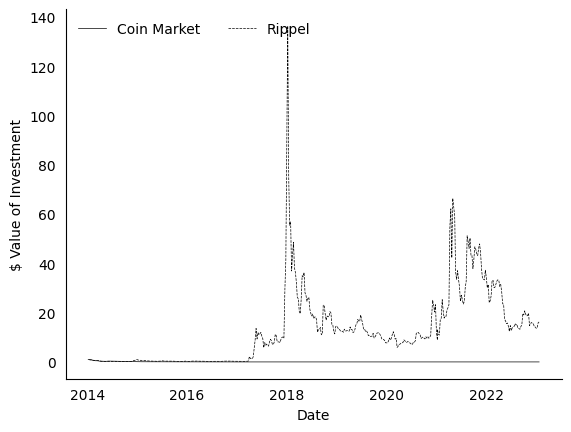

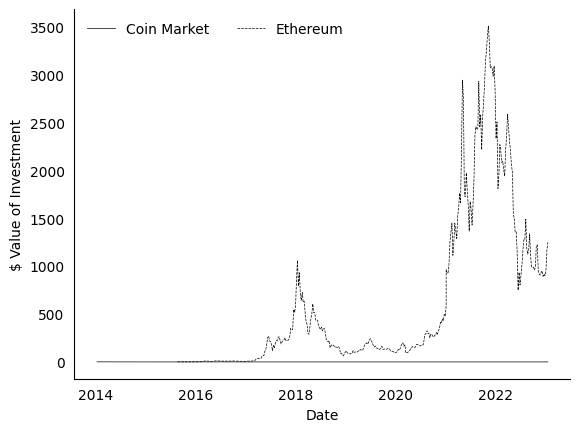

Figure 1. Cryptocurrency market and major coins. This figure plots the aggregate cryptocurrency market against Bitcoin, Ripple, and Ethereum.


In [ ]:
# plotting the time series graphs
import matplotlib.pyplot as plt, datetime, numpy as np, math

bitcoin_weekly_returns = weekly_returns_data[weekly_returns_data["coin_id"] == "bitcoin"]
ripple_weekly_returns = weekly_returns_data[weekly_returns_data["coin_id"] == "ripple"]
ethereum_weekly_returns = weekly_returns_data[weekly_returns_data["coin_id"] == "ethereum"]

year_and_week = (market_weekly_returns.index.isocalendar().year + market_weekly_returns.index.isocalendar().week / 52).tolist()

market_weekly_returns["market_index"] = (1 + market_weekly_returns["market_return"]).cumprod()
# Set the first value of return_index to 1
market_weekly_returns.iloc[0,1] = 1
# imputing missing index values with the last non-missing value
market_weekly_returns["market_index"] = market_weekly_returns["market_index"].fillna(method='ffill')
market_index = market_weekly_returns["market_index"].tolist()

bitcoin_weekly_returns["bitcoin_index"] = (1 + bitcoin_weekly_returns["return"]).cumprod()
bitcoin_weekly_returns.iloc[0,1] = 1
bitcoin_weekly_returns["bitcoin_index"] = bitcoin_weekly_returns["bitcoin_index"].fillna(method='ffill')
bitcoin_index = bitcoin_weekly_returns["bitcoin_index"].tolist()

ripple_weekly_returns["ripple_index"] = (1 + ripple_weekly_returns["return"]).cumprod()
ripple_weekly_returns.iloc[0,1] = 1
ripple_weekly_returns["ripple_index"] = ripple_weekly_returns["ripple_index"].fillna(method='ffill')
ripple_index = ripple_weekly_returns["ripple_index"].tolist()

ethereum_weekly_returns["ethereum_index"] = (1 + ethereum_weekly_returns["return"]).cumprod()
ethereum_weekly_returns.iloc[0,1] = 1
ethereum_weekly_returns["ethereum_index"] = ethereum_weekly_returns["ethereum_index"].fillna(method='ffill')
ethereum_index = ethereum_weekly_returns["ethereum_index"].tolist()

vars = [bitcoin_index, ripple_index, ethereum_index]
labels = ["Bitcoin", "Rippel", "Ethereum"]
# max = [41, 151, 501]
max = [10000, 10000, 10000]
step_size = [10, 50, 100]

for i in range(3):
    plt.plot(year_and_week, np.array(market_index), color="black", label="Coin Market", linewidth=0.5)
    plt.plot(year_and_week, np.array(vars[i]), color="black", linestyle="dashed", label = labels[i], linewidth=0.5)
    plt.tick_params(color="white")
    # plt.yticks(np.arange(0, max[i], step_size[i]))
    plt.xticks(np.arange(start_date.year, end_date.year + 1, 2))
    plt.xlabel("Date")
    plt.ylabel("$ Value of Investment")
    plt.rcParams['axes.spines.right'] = False
    plt.rcParams['axes.spines.top'] = False
    plt.legend(frameon=False, prop={"size": 10}, loc="upper left", ncol=2)
    plt.show()
print("Figure 1. Cryptocurrency market and major coins. This figure plots the aggregate cryptocurrency market against Bitcoin, Ripple, and Ethereum.")


<a id="II._Cross-Sectional_Return_Predictor"></a>
# II. Cross-Sectional Return Predictor

<a id="A._Size_Characteristics"></a>
## A. Size Characteristics

In [ ]:
# computing the zero-investment long-short strategies based on the size-related characteristics of market capitalization, price, maximum day price, and age
if not os.path.exists(directory + "/quintile_size_data.csv"):
    print("Computing the excess long-short strategies for the different size characteristics.")
    # creating the data for the size characteristics in coins_weekly_returns
    # adding log_market_cap
    weekly_returns_data["log_market_cap"] = np.log(weekly_returns_data["market_cap"])
    # adding log_price
    weekly_returns_data["log_price"] = np.log(weekly_returns_data["price"])
    # adding log_max_price
    # this step might take a while
    weekly_returns_data["log_max_price"] = np.log(helpers.convert_frequency(daily_trading_data, method="max")["price"])
    # adding age as the number of days listed since the first trading day of that respective coin (considering that the time period begins on 2014-01-01)
    weekly_returns_data["age"] = weekly_returns_data.groupby("coin_id")["return"].transform(lambda x: np.maximum(0, (x.index - x.first_valid_index()).days) if x.first_valid_index() is not None else pd.Series([0] * len(x)))
    # making sure no dates were lost
    date_range = pd.date_range(start=market_weekly_returns.index.min(), end=market_weekly_returns.index.max(), freq="W-SUN")
    market_weekly_returns = market_weekly_returns.reindex(date_range)

    # "risk_free_rate" now is a pd dataframe with columns for date and DGS1MO (the risk-free rate)
    quintile_data = risk_free_rate
    size_characteristics = ["log_market_cap", "log_price", "log_max_price", "age"]
    for size_characteristic in size_characteristics:
        quintile_returns_data = helpers.quintile_returns(weekly_returns_data, size_characteristic)
        quintile_returns_data.reset_index(drop=True, inplace=True)
        # subtracting the risk-free rate from every column of quintile returns
        quintile_returns_data = quintile_returns_data.subtract(quintile_data["DGS1MO"], axis=0)
        quintile_data = pd.concat([quintile_data, quintile_returns_data], axis=1)
        # computing the excess returns for the long-short strategy
        quintile_data[size_characteristic + "_excess_ls"] = quintile_data[size_characteristic + "_q5"] - quintile_data[size_characteristic + "_q1"] - quintile_data["DGS1MO"]

    # downloading the data
    quintile_data.to_csv(directory + "/quintile_size_data.csv")
else:
    print("The data for the excess long-short strategies for the different size characteristics has already been computed.")
    quintile_data = pd.read_csv(directory + "/quintile_size_data.csv", index_col=["date"])

print("Table 2 lists the return predictor definitions and can be found in the paper.")

# inverting the colors in the PDF in case the user is using dark mode
if input("Is your editor is dark mode? y/n ") in ["Y", "y"]:
    invert = True
else:
    invert = False

# use "\symbol{37}" in the latex file for the percentage sign
helpers.render_quintiles(quintile_data, "latex_templates/size_quintiles.tex", ["log_market_cap", "log_price", "log_max_price", "age"], invert)

# creates a temporary PDF file named "cover.pdf"
# repeating the process overwrites the file

pdf_path = os.getcwd() + "/cover.pdf"
# printing the PDF
# this code has to be in the main file
img = Image(filename=pdf_path, resolution=100)
img

Computing the excess long-short strategies for the different size characteristics.


/Users/Marc/.pyenv/versions/3.11.1/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Marc/.pyenv/versions/3.11.1/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/Marc/.pyenv/versions/3.11.1/lib/python3.11/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/var/folders/cn/dd2qmn7d0_7_sh8vgy3mg1pm0000gn/T/ipykernel_18268/3910176875.py:25: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects.
  quintile_returns_data = quintile_returns_data.subtract(quintile_data["DGS1MO"], axis=0)
/var/folders/cn/dd2qmn7d0_7_sh8vgy3mg1pm0000gn/T/ipykernel_18268/3910176875.py:25: RuntimeWarning: '<' not supp

ValueError: Bin labels must be one fewer than the number of bin edges

<a id="B._Momentum_Characteristics"></a>
## B. Momentum Characteristics

In [ ]:
# constructing the return quintiles for the zero-investment long-short strategies based on past 1-, 2-, 3-, 4-, 1-to-4-, 8-, 16-, 50-, and 8-week returns

# downloading the data since the returns computation process might also take a long time
# if the file for weekly returns data does not already exist
if not os.path.exists(directory + "/quintile_momentum_data.csv"):
    print("Computing the momentum excess long-short strategies for the past return series.")

    # 1-week past returns
    weekly_returns_data["one_week_momentum"] = weekly_returns_data["return"]
    # 2-week past returns
    # here the transition from one data set to another is not an issue since the variable is always NaN when the return in the same week is NaN
    weekly_returns_data["two_week_momentum"] = (1 + weekly_returns_data["return"]).rolling(2).apply(lambda x: x.prod() - 1, raw=True)
    # 3-week past returns
    weekly_returns_data["three_week_momentum"] = (1 + weekly_returns_data["return"]).rolling(3).apply(lambda x: x.prod() - 1, raw=True)
    # 4-week past returns
    weekly_returns_data["four_week_momentum"] = (1 + weekly_returns_data["return"]).rolling(4).apply(lambda x: x.prod() - 1, raw=True)
    # 1-to-4-week past returns
    # applying the transformation to every coin ID subset separately to avoid complications at the transitions between 2 coin IDs 
    weekly_returns_data["one_to_four_week_momentum"] = weekly_returns_data.groupby("coin_id")["return"].transform(lambda x: (1 + x).shift(1).rolling(3).apply(lambda x: x.prod() - 1, raw=True))
    # 8-week past returns
    weekly_returns_data["eight_week_momentum"] = (1 + weekly_returns_data["return"]).rolling(8).apply(lambda x: x.prod() - 1, raw=True)
    # 16-week past returns
    weekly_returns_data["sixteen_week_momentum"] = (1 + weekly_returns_data["return"]).rolling(16).apply(lambda x: x.prod() - 1, raw=True)
    # 50-week past returns
    weekly_returns_data["fifty_week_momentum"] = (1 + weekly_returns_data["return"]).rolling(50).apply(lambda x: x.prod() - 1, raw=True)
    # 100-week past returns
    weekly_returns_data["one_hundred_week_momentum"] = (1 + weekly_returns_data["return"]).rolling(100).apply(lambda x: x.prod() - 1, raw=True)

    # "risk_free_rate" now is a pd dataframe with columns for year, month, and DGS1MO (the risk-free rate)
    quintile_data = risk_free_rate
    for momentum_return_series in ["one_week_momentum", "two_week_momentum", "three_week_momentum", "four_week_momentum", "one_to_four_week_momentum", "eight_week_momentum", "sixteen_week_momentum", "fifty_week_momentum", "one_hundred_week_momentum"]:
        # here we can use the quintile function for the past returns
        quintile_returns_data = helpers.quintile_returns(weekly_returns_data, momentum_return_series)
        quintile_returns_data.reset_index(drop=True, inplace=True)
        # subtracting the risk-free rate from every column of quintile returns
        quintile_returns_data = quintile_returns_data.subtract(quintile_data["DGS1MO"], axis=0)
        quintile_data = pd.concat([quintile_data, quintile_returns_data], axis=1)
        # computing the excess returns for the long-short strategy
        quintile_data[momentum_return_series + "_excess_ls"] = quintile_data[momentum_return_series + "_q5"] - quintile_data[momentum_return_series + "_q1"] - quintile_data["DGS1MO"]
    # downloading the data
    quintile_data.to_csv(directory + "/quintile_momentum_data.csv")
else:
    print("The data for the excess long-short strategies for the different momentum strategies has already been computed.")
    quintile_data = pd.read_csv(directory + "/quintile_momentum_data.csv", index_col=["date"])
    quintile_data.index = pd.to_datetime(quintile_data.index)

# inverting the colors in the PDF in case the user is using dark mode
if input("Is your editor is dark mode? y/n ") in ["Y", "y"]:
    invert = True
else:
    invert = False

helpers.render_quintiles(quintile_data, "latex_templates/momentum_quintiles.tex", ["one_week_momentum", "two_week_momentum", "three_week_momentum", "four_week_momentum", "one_to_four_week_momentum", "eight_week_momentum", "sixteen_week_momentum", "fifty_week_momentum", "one_hundred_week_momentum"], invert)

# creates a temporary PDF file named "cover.pdf"
# repeating the process overwrites the file

pdf_path = os.getcwd() + "/cover.pdf"
# printing the PDF
# this code has to be in the main file
img = Image(filename=pdf_path, resolution=100)
img

<a id="C._Volume_Characteristics"></a>
## C. Volume Characteristics

In [ ]:
if not os.path.exists(directory + "/quintile_volume_data.csv"):
    print("Computing the excess long-short strategies for the total trading volume.")

    # adding average_volume
    weekly_returns_data["log_average_volume"] = np.log(helpers.convert_frequency(daily_trading_data["total_volume"], method="mean")["total_volume"])
    # adding price_times_volume
    weekly_returns_data["price_times_volume"] = weekly_returns_data["log_average_volume"] * weekly_returns_data["price"]
    # adding price_times_volume_scaled_market_cap
    weekly_returns_data["price_times_volume_scaled_market_cap"] = weekly_returns_data["price_times_volume"] / weekly_returns_data["market_cap"]
    
    # "risk_free_rate" now is a pd dataframe with columns for date and DGS1MO (the risk-free rate)
    quintile_data = risk_free_rate
    for volume_measure in ["log_average_volume", "price_times_volume", "price_times_volume_scaled_market_cap"]:
        # here we can use the quintile function for the past returns
        quintile_returns_data = helpers.quintile_returns(weekly_returns_data, volume_measure)
        quintile_returns_data.reset_index(drop=True, inplace=True)
        # subtracting the risk-free rate from every column of quintile returns
        quintile_returns_data = quintile_returns_data.subtract(quintile_data["DGS1MO"], axis=0)
        quintile_data = pd.concat([quintile_data, quintile_returns_data], axis=1)
        # computing the excess returns for the long-short strategy
        quintile_data[volume_measure + "_excess_ls"] = quintile_data[volume_measure + "_q5"] - quintile_data[volume_measure + "_q1"] - quintile_data["DGS1MO"]
    # downloading the data
    quintile_data.to_csv(directory + "/quintile_volume_data.csv")
else:
    print("The data for the excess long-short strategies for the different size characteristics has already been computed.")
    quintile_data = pd.read_csv(directory + "/quintile_volume_data.csv", index_col=["date"])
    quintile_data.index = pd.to_datetime(quintile_data.index)

print("Table 2 lists the return predictor definitions and can be found in the paper.")

# inverting the colors in the PDF in case the user is using dark mode
if input("Is your editor is dark mode? y/n ") in ["Y", "y"]:
    invert = True
else:
    invert = False

helpers.render_quintiles(quintile_data, "latex_templates/volume_quintiles.tex", ["log_average_volume", "price_times_volume", "price_times_volume_scaled_market_cap"], invert)

# creates a temporary PDF file named "cover.pdf"
# repeating the process overwrites the file

pdf_path = os.getcwd() + "/cover.pdf"
# printing the PDF
# this code has to be in the main file
img = Image(filename=pdf_path, resolution=100)
img

<a id="D._Volatility_Characteristics"></a>
## D. Volatility Characteristics

In [ ]:
if not os.path.exists(directory + "/quintile_volatility_data.csv"):

    import statsmodels.api as sm
    from numpy.lib.stride_tricks import sliding_window_view
    
    print("Computing the excess long-short strategies for the past return series.")

    # computing the returns of the daily data
    daily_trading_data["return"] = daily_trading_data.groupby("coin_id")["price"].pct_change()
    # computing the excess returns of the daily data
    daily_trading_data["excess_return"] = daily_trading_data["return"] - risk_free_rate_daily_data["DGS1MO"]
    # computing the daily excess crypto market factor
    daily_trading_data["market_return"] = daily_trading_data.groupby(daily_trading_data.index).apply(lambda x: (x["return"]*x["market_cap"]).sum()/x["market_cap"].sum()) - risk_free_rate_daily_data["DGS1MO"]
    # computing the market return factor lagged by 1 day
    daily_trading_data["market_lagged_one_day"] = daily_trading_data["market_return"].shift(1)
    # computing the market return facotr lagged by 2 days
    daily_trading_data["market_lagged_two_days"] = daily_trading_data["market_return"].shift(2)
    # filling in the missing values with NaNs
    date_range = pd.date_range(start=daily_trading_data.index.min(), end=daily_trading_data.index.max(), freq="D")
    daily_trading_data = daily_trading_data.reindex(date_range)
    daily_trading_data.index.name = "date"

    # imputing a value of 0 for the missing values for return, excess_return, and market_return
    daily_trading_data["return"].fillna(0, inplace=True)
    daily_trading_data["excess_return"].fillna(0, inplace=True)
    daily_trading_data["market_return"].fillna(0, inplace=True)
    daily_trading_data["market_lagged_one_day"].fillna(0, inplace=True)
    daily_trading_data["market_lagged_two_days"].fillna(0, inplace=True)
    # replacing volumes of 0 with NaN to avoid division by 0
    daily_trading_data["total_volume"].replace([0, 0.0], np.nan)

    dict = {"beta": [], "residual_std": [], "r_squared_difference": [], "standard_deviation": [], "max_return": [], "volume_std": [], "abs_return_per_volume": []}
    for coin_id in daily_trading_data["coin_id"].unique():
        sub_df = daily_trading_data[daily_trading_data["coin_id"] == coin_id]
        sub_df = sub_df.copy()
        for index in sub_df.index:
            # converting to weekly data
            # 6 stands for Sunday
            if index.dayofweek == 6:
                days = min(len(sub_df[sub_df.index <= index]), 365)
                # sliding_window_view return the rolling window for all indices but we are only interested in the last day, so we use [-1]
                model = sm.OLS(sliding_window_view(sub_df[sub_df.index <= index]["market_return"], days)[-1], sm.add_constant(sliding_window_view(sub_df[sub_df.index <= index]["excess_return"], days)[-1])).fit()
                # dict["beta"].append(sub_df[sub_df.index <= index][["return", "market_return"]].rolling(days).cov().unstack()["return"]["market_return"].tolist()[-1]/sub_df[sub_df.index <= index]["market_return"].rolling(days).var().tolist()[-1])
                dict["beta"].append(model.params[1])
                # computing the regression residuals
                # this step might be unpractical since computing all residuals is very computationally expensive
                dict["residual_std"].append(model.resid.std())
                new_model = sm.OLS(sliding_window_view(sub_df[sub_df.index <= index]["market_return"], days)[-1], sm.add_constant(pd.DataFrame(data=[sliding_window_view(sub_df[sub_df.index <= index]["excess_return"], days)[-1], sliding_window_view(sub_df[sub_df.index <= index]["market_lagged_one_day"], days)[-1], sliding_window_view(sub_df[sub_df.index <= index]["market_lagged_two_days"], days)[-1]]).T)).fit()
                dict["r_squared_difference"].append(new_model.rsquared - model.rsquared)
                # for the standard deviation we just consider the return in the portfolio formation week (Monday to Sunday)
                days = min(len(sub_df[sub_df.index <= index]), 7)
                dict["standard_deviation"].append(sub_df[sub_df.index <= index]["return"].rolling(days).std().tolist()[-1])
                dict["max_return"].append(sub_df[sub_df.index <= index]["return"].rolling(days).max().tolist()[-1])
                dict["volume_std"].append(sub_df[sub_df.index <= index]["total_volume"].rolling(days).std().tolist()[-1])
                dict["abs_return_per_volume"].append(np.nanmean((np.abs(sliding_window_view(sub_df[sub_df.index <= index]["return"], days)[-1]) / sliding_window_view(sub_df[sub_df.index <= index]["total_volume"], days)[-1])))

    weekly_returns_data["beta"] = dict["beta"]
    weekly_returns_data["residual_std"] = dict["residual_std"]
    weekly_returns_data["r_squared_difference"] = dict["r_squared_difference"]
    weekly_returns_data["standard_deviation"] = dict["standard_deviation"]
    weekly_returns_data["max_return"] = dict["max_return"]
    weekly_returns_data["log_volume_std"] = np.log(dict["volume_std"])
    weekly_returns_data["abs_return_per_volume"] = dict["abs_return_per_volume"]
    # computing beta_squared
    weekly_returns_data["beta_squared"] = weekly_returns_data["beta"] ** 2

    quintile_data = risk_free_rate
    for volatility_measure in ["beta", "residual_std", "r_squared_difference", "standard_deviation", "max_return", "log_volume_std", "abs_return_per_volume", "beta_squared"]:
        # here we can use the quintile function for the past returns
        quintile_returns_data = helpers.quintile_returns(weekly_returns_data, volatility_measure)
        quintile_returns_data.reset_index(drop=True, inplace=True)
        # subtracting the risk-free rate from every column of quintile returns
        quintile_returns_data = quintile_returns_data.subtract(quintile_data["DGS1MO"], axis=0)
        quintile_data = pd.concat([quintile_data, quintile_returns_data], axis=1)
        # computing the excess returns for the long-short strategy
        quintile_data[volatility_measure + "_excess_ls"] = quintile_data[volatility_measure + "_q5"] - quintile_data[volatility_measure + "_q1"] - quintile_data["DGS1MO"]
    # downloading the data
    quintile_data.to_csv(directory + "/quintile_volatility_data.csv")
else:
    print("The data for the excess long-short strategies for the different volatility strategies has already been computed.")
    quintile_data = pd.read_csv(directory + "/quintile_volatility_data.csv", index_col=["date"])
    quintile_data.index = pd.to_datetime(quintile_data.index)

# inverting the colors in the PDF in case the user is using dark mode
if input("Is your editor is dark mode? y/n ") in ["Y", "y"]:
    invert = True
else:
    invert = False

helpers.render_quintiles(quintile_data, "latex_templates/volatility_quintiles.tex", ["beta", "residual_std", "r_squared_difference", "standard_deviation", "max_return", "log_volume_std", "abs_return_per_volume", "beta_squared"], invert)

# creates a temporary PDF file named "cover.pdf"
# repeating the process overwrites the file

pdf_path = os.getcwd() + "/cover.pdf"
# printing the PDF
# this code has to be in the main file
img = Image(filename=pdf_path, resolution=100)
img

<a id="III._Cryptocurrency_Factors"></a>
# III. Cryptocurrency Factors

<a id="A._Cryptocurrency_Factor_Model"></a>
# A. Cryptocurrency Factor Model

<a id="B._Principal_Component_Analysis"></a>
# B. Principal Component Analysis